# Bi-Directional LSTM neural network trained whit K-Fold Cross Validation
## VOU_Blazars dataset

* Impostazione per uso della GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from tensorflow import keras
from keras import layers
print("TensorFlow version:", tf.__version__)

import numpy as np
print('Numpy version:', np.__version__)

from matplotlib import pyplot as plt 

TensorFlow version: 2.8.0
Numpy version: 1.21.6


In [4]:
cd drive/MyDrive/Colab\ Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [5]:
%ls

 BlazarDNN.ipynb                       Librerie.ipynb
 BlazarDNN_vecchio.ipynb               media.ipynb
 blazar_model_colab.ipynb              model.png
 blazar_model_colab_v3.ipynb           model_v5/
 blazar_model_colab_v5.ipynb           model_v6/
 blazar_model_colab_v6.ipynb           model_v6_nokfold/
 blazar_model_colab_v6_nokfold.ipynb   model_voub/
 blazar_model_colab_v6_voub.ipynb      newfile.txt
 blazar_model_colab_v7_plot.ipynb      nn_data.npz
'Copia di KerasSimple.ipynb'           nn_data_v2.npz
'Copy of CNN tutorial.ipynb'           nn_data_v3.npz
'Copy of Jet_exploration.ipynb'        nn_datavoub.npz
 example_txs0506+056.ipynb             __pycache__/
 k_model_pot.py                        TXS0506056.txt
'Lezione GPU.ipynb'


* Final preprocessing dei dati

In [6]:
# nn_data.npz archivio con i 2 np.ndarray 'bl_data' (4627, 529, 2) 'agn_data' (4059, 529, 2) e  np.array 'nn_freq_data' (529,)
# nn_data.npz ha i flag nei dati sed a 1 per blazars e a 0 per agn
# nn_data_v2.npz ha i flag a 1 per blazar e agn dove abbiamo misura vera del flusso
#                i label per distinguere tra blazar e agn da costruire a parte
# nn_data_v3.npz è corretto rispetto a *_v2.npz: non ha i nan, non ha flussi negativi e non ha flussi superiori a 10^-5
nn_data = np.load('nn_datavoub.npz')
#nn_data = np.load('nn_data_v3.npz')

bl_data = nn_data['bl_data']
agn_data = nn_data['agn_data']
set_freq = nn_data['nn_freq_data']

In [7]:
print(bl_data.shape)
print(agn_data.shape)

(5699, 535, 2)
(3488, 535, 2)


In [8]:
# Verifica che non ci siano valori NAN inaspettati nelle misure di flusso
with np.printoptions(threshold=np.inf):
  nanbl_idx=np.argwhere(np.isnan(bl_data))
  nanagn_idx=np.argwhere(np.isnan(agn_data))
  print('Indici delle sed blazar con NAN: ',nanbl_idx)
  print('Indici delle sed agn con NAN: ',nanagn_idx)

Indici delle sed blazar con NAN:  []
Indici delle sed agn con NAN:  []


In [9]:
# Dati pronti per essere concatenati

data = np.concatenate((bl_data, agn_data), axis =0)
print(data.shape)

(9187, 535, 2)


Adesso posso riscalare i miei valori di flusso tra 0 e 1

In [10]:
# funzione per normalizzare dati
ptp=np.ptp(data[:,:,0])
min = np.min(data[:,:,0])
max = np.max(data[:,:,0])
print(min)
print(max)
print(ptp)
data[:,:,0]= (data[:,:,0]-min)/ptp


0.0
6.451e-06
6.451e-06


In [11]:
# Creo le label
label = np.concatenate((np.ones(bl_data.shape[0]),np.zeros(agn_data.shape[0])))

In [12]:
label.shape

(9187,)

In [13]:
bl_data = data[0:5698]
agn_data = data[5699:]
bl_label = label[0:5698]
agn_label = label[5699:]

In [14]:
from sklearn.model_selection import train_test_split

data_train_bl, data_test_bl, l_train_bl, l_test_bl = train_test_split(bl_data, bl_label, test_size=0.1, random_state=1)
data_train_agn, data_test_agn, l_train_agn, l_test_agn = train_test_split(agn_data, agn_label, test_size=0.1, random_state=1)

In [15]:
len(data_train_bl)

5128

In [16]:
len(data_train_agn)

3139

In [17]:
data_train_bl_tmp = data_train_bl[0:3138]
l_train_bl_tmp = l_train_bl[0:3138]

In [18]:
data = np.concatenate((data_train_bl_tmp,data_train_agn))
data_test_bl = np.concatenate((data_test_bl, data_train_bl[3139:]))
l_test_bl = np.concatenate((l_test_bl,l_train_bl[3139:]))
l_train_bl = l_train_bl_tmp

In [19]:
label = np.concatenate((l_train_bl, l_train_agn))
label.shape

(6277,)

In [20]:
# Permuto il train dataset
permutation = np.random.permutation(data.shape[0])
data_train=data[permutation]
l_train=label[permutation]

In [21]:
l_test=np.concatenate((l_test_bl,l_test_agn))
data_test=np.concatenate((data_test_bl,data_test_agn))

In [22]:
# Definisco le dimensione dell'array di Input
ishape=data.shape[1:]
ishape

(535, 2)

In [23]:
init = tf.keras.initializers.LecunNormal(5)

model = keras.Sequential()
model.add(keras.Input(shape = ishape)) # input
model.add(keras.layers.Conv1D(filters = 128,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Conv1D(filters = 256,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Conv1D(filters = 512,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(1024)))
model.add(keras.layers.Dense(512, activation='relu',kernel_initializer=init, use_bias=True))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(256, activation='relu', kernel_initializer=init, use_bias=True))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1, activation='relu', kernel_initializer=init, use_bias=True))

opt = tf.keras.optimizers.Adadelta(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary() # stampa modello riga per riga

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 535, 128)          896       
                                                                 
 activation (Activation)     (None, 535, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 267, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 267, 256)          98560     
                                                                 
 activation_1 (Activation)   (None, 267, 256)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 133, 256)         0         
 1D)                                                    

In [ ]:
#from keras.utils import plot_model

keras.utils.plot_model(model, to_file ='model.png',show_shapes=True,rankdir='LR')

In [24]:
# split of train dataset in 9 fold: 8 for training, 1 for validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=9, shuffle = True, random_state = 1)

In [25]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

save_dir = 'model_voub/'
fold_var = 0
history_list = []
for train_idx, val_idx in kf.split(data_train):
  fold_var = fold_var+1
  print(train_idx.shape, val_idx.shape)
  # CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4)
  callbacks_list = [checkpoint,earlystopping]
  history=model.fit(x=data_train[train_idx],y=l_train[train_idx],validation_data=(data_train[val_idx],l_train[val_idx]),epochs=20, callbacks=callbacks_list)
  np.save(f'model_v6/my_history_{fold_var}.npy',history.history)
  history_list.append(history)

(5579,) (698,)
Epoch 1/20
175/175 [==============================] - ETA: 0s - loss: 3.0593 - accuracy: 0.5010
Epoch 1: val_accuracy improved from -inf to 0.49284, saving model to model_voub/model_1.h5
175/175 [==============================] - 63s 278ms/step - loss: 3.0593 - accuracy: 0.5010 - val_loss: 1.8235 - val_accuracy: 0.4928
Epoch 2/20
175/175 [==============================] - ETA: 0s - loss: 1.9606 - accuracy: 0.5010
Epoch 2: val_accuracy did not improve from 0.49284
175/175 [==============================] - 47s 270ms/step - loss: 1.9606 - accuracy: 0.5010 - val_loss: 1.4825 - val_accuracy: 0.4928
Epoch 3/20
175/175 [==============================] - ETA: 0s - loss: 1.4336 - accuracy: 0.5010
Epoch 3: val_accuracy did not improve from 0.49284
175/175 [==============================] - 47s 270ms/step - loss: 1.4336 - accuracy: 0.5010 - val_loss: 1.2080 - val_accuracy: 0.4928
Epoch 4/20
175/175 [==============================] - ETA: 0s - loss: 1.1183 - accuracy: 0.5012
Epoch 

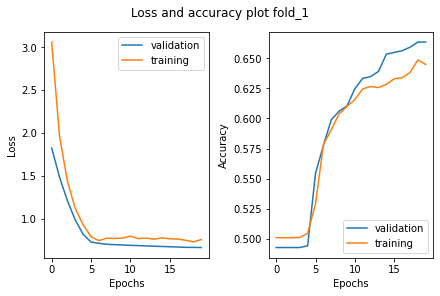

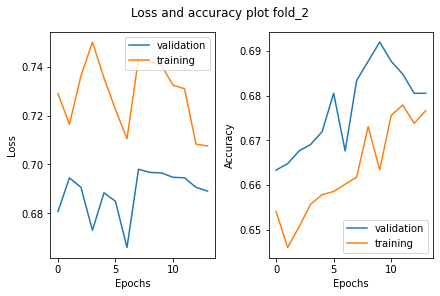

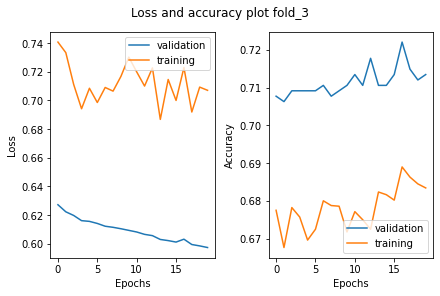

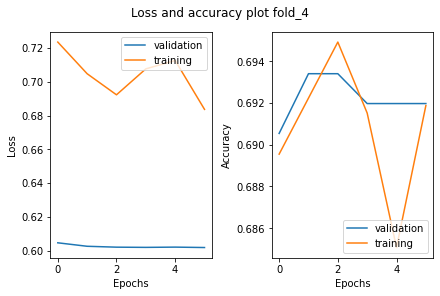

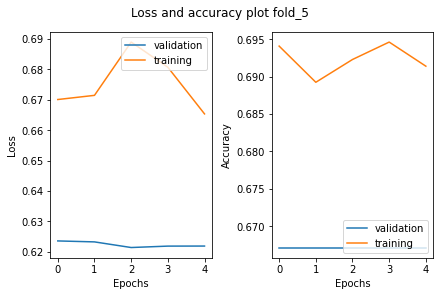

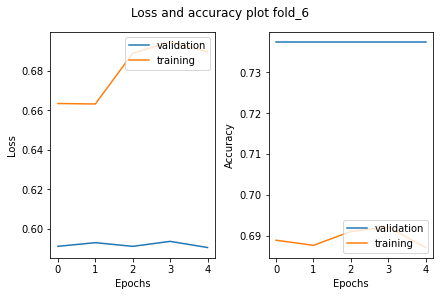

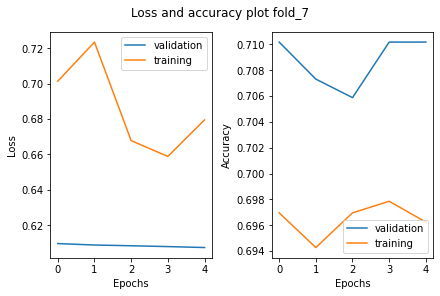

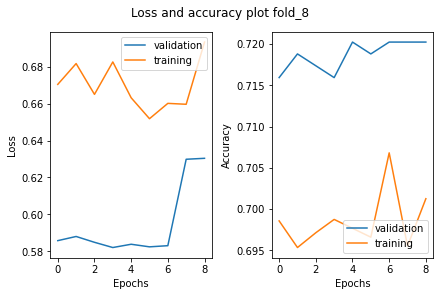

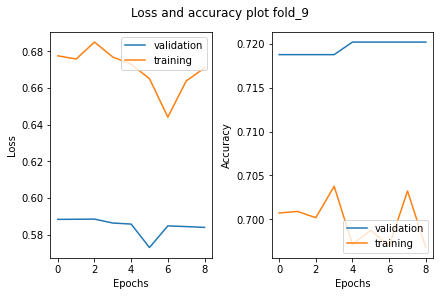

In [28]:
i = 0
for history in history_list:
  i=i+1
  #print(history.history.keys())
  fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
  fig.suptitle(f'Loss and accuracy plot fold_{i}')

  ax1.plot(history.history["val_loss"], label='validation')
  ax1.plot(history.history["loss"], label='training')
  ax1.legend(loc="upper right")
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  #ax1.set_xlim(-0.5,10)
  #ax1.set_ylim(0.1,0.7)
  
  ax2.plot(history.history["val_accuracy"], label='validation')
  ax2.plot(history.history["accuracy"], label='training')
  ax2.legend(loc="lower right")
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  #ax2.set_xlim(-0.5,10)
  #ax2.set_ylim(0.5,0.9)
  fig.savefig(f'model_voub/plot_{i}')
  fig.show()

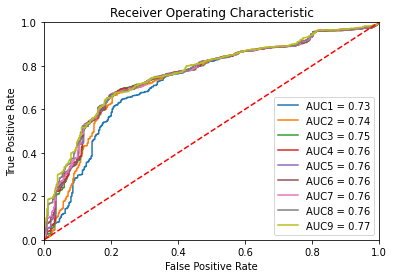

In [30]:
# ROC Curve and AUC value with error
import sklearn.metrics as metrics
from keras import models

plt.figure()
for i in range(9):
  model=models.load_model(f'model_voub/model_{i+1}.h5')
  # calculate the fpr and tpr for all thresholds of the classification
  probs = model.predict(data_test)
  fpr, tpr, threshold = metrics.roc_curve(l_test, probs)
  roc_auc = metrics.auc(fpr, tpr)

  plt.plot(fpr, tpr, label = f'AUC{i+1} = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')

plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(f'model_voub/plot_auc')
plt.show()